In [1]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,\
                                    Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from matplotlib import pyplot as plt
import datetime
import os

########### INICIO DEFINICIÓN RESNET ################

#Definimos la Capa activación:
# Relu + Batch Normalization
def relu_bn(inputs: Tensor) -> Tensor:
    relu = ReLU()(inputs)    #Hacemos Relu sobre el Tensor de Entrada
    bn = BatchNormalization()(relu)    #Hacemos Batch Normalization sobre la salida de Relu
    return bn

#Definimos el bloque Residual
#Capa Convolucional
#Capa Activación (Relu + Batch Normalization)
#Capa Convolucional (Relu + Batch Normalization)
#Adición Residuo
#Capa Activación (Relu + Batch Normalization)

def residual_block(x: Tensor, downsample: bool, filters: int, kernel_size: int = 3) -> Tensor:
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:   #Si el parametro downsample = true, entonces el stride es 2, para hacer que la imagen se reduzca a la mitad
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

#Definimos la Red ResNet
def create_res_net():

    inputs = Input(shape=(32, 32, 3))  #Input = al de las imagenes de CIFAR10, 32 x 32 x RGB
    num_filters = 64   #Cantidad de Kernels inicial (Filtros)

    #Las capas se van "Stackeando" (Apilando)
    #La primera capa es la de Inputs

    t = BatchNormalization()(inputs) #Luego se agrega una capa de Batch Normalization
    t = Conv2D(kernel_size=3,        #Luego una capa Convolucional con 64 filtros
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)                   #Luego una capa Relu+BatchNormalization

    #La red va así
    #Inputs
    #BatchNormalization
    #Convolutional/64)
    #Activation(Relu+BatchNormalization)

    num_blocks_list = [2, 5, 5, 2]   #Luego, se agregan los siguientes bloques residuales (2, 5, 5, 2)

    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
        num_filters *= 2             #Por cada bloque agregado, se duplica la cantidad de Kernels (Filtros)

    t = AveragePooling2D(4)(t)       #La Red termina con Average Pooling de 4
    t = Flatten()(t)                 #Se aplana a un vector
    outputs = Dense(10, activation='softmax')(t) #Hacemos distrinución de probabilidad de 10 items con SoftMax

    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model
########### FIN DEFINICIÓN RESNET ################

def create_plain_net():

    inputs = Input(shape=(32, 32, 3))
    num_filters = 64

    t = BatchNormalization()(inputs)
    t = Conv2D(kernel_size=3,
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)

    num_blocks_list = [4, 10, 10, 4]
    for i in range(len(num_blocks_list)):
        num_blocks = num_blocks_list[i]
        for j in range(num_blocks):
            downsample = (j==0 and i!=0)
            t = Conv2D(kernel_size=3,
                       strides= (1 if not downsample else 2),
                       filters=num_filters,
                       padding="same")(t)
            t = relu_bn(t)
        num_filters *= 2

    t = AveragePooling2D(4)(t)
    t = Flatten()(t)
    outputs = Dense(10, activation='softmax')(t)

    model = Model(inputs, outputs)

    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

model = create_res_net() # or create_plain_net()
model.summary()



170498071/170498071 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 3)            12        ['input_1[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           1792      ['batch_normalization[0][0]'] 
                                                                                                  
 re_lu (ReLU)              

In [3]:
timestr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
name = 'cifar-10_res_net_30-'+timestr # or 'cifar-10_plain_net_30-'+timestr

checkpoint_path = "/content/drive/MyDrive/Coordinación Linea/2022S1/DLY0100/Checkpoints/ResNetCifar10/"+name+"/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
os.system('mkdir {}'.format(checkpoint_dir))

# save model after each epoch
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1
)
tensorboard_callback = TensorBoard(
    log_dir='/content/drive/MyDrive/Coordinación Linea/2022S1/DLY0100/Checkpoints/ResNetCifar10/tensorboard_logs/'+name,
    histogram_freq=1
)

hist= model.fit(
    x=x_train,
    y=y_train,
    epochs=20,
    verbose=1,
    validation_data=(x_test, y_test),
    batch_size=128,
    callbacks=[cp_callback, tensorboard_callback]
)

Epoch 1/20
391/391 [==============================] - ETA: 0s - loss: 1.4418 - accuracy: 0.4877
Epoch 1: saving model to /content/drive/MyDrive/Coordinación Linea/2022S1/DLY0100/Checkpoints/ResNetCifar10/cifar-10_res_net_30-20240522-192951/cp-0001.ckpt
391/391 [==============================] - 113s 224ms/step - loss: 1.4418 - accuracy: 0.4877 - val_loss: 1.7300 - val_accuracy: 0.4866
Epoch 2/20
391/391 [==============================] - ETA: 0s - loss: 0.9753 - accuracy: 0.6628
Epoch 2: saving model to /content/drive/MyDrive/Coordinación Linea/2022S1/DLY0100/Checkpoints/ResNetCifar10/cifar-10_res_net_30-20240522-192951/cp-0002.ckpt
391/391 [==============================] - 86s 220ms/step - loss: 0.9753 - accuracy: 0.6628 - val_loss: 11.4809 - val_accuracy: 0.5555
Epoch 3/20
391/391 [==============================] - ETA: 0s - loss: 0.7495 - accuracy: 0.7451
Epoch 3: saving model to /content/drive/MyDrive/Coordinación Linea/2022S1/DLY0100/Checkpoints/ResNetCifar10/cifar-10_res_net_

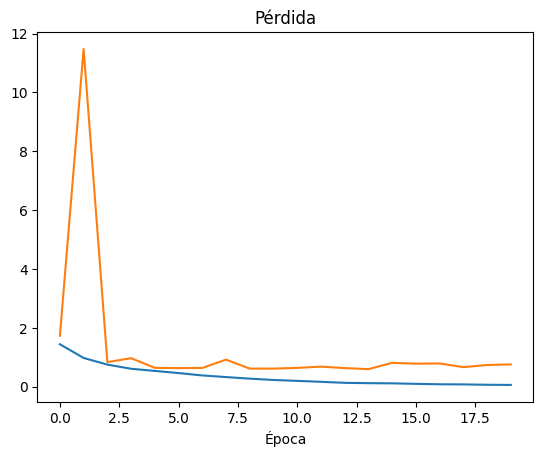

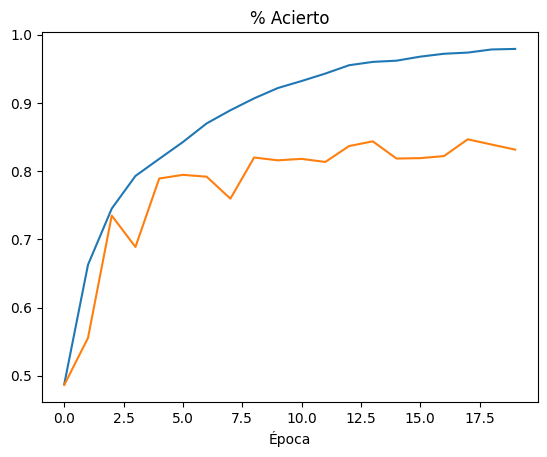

In [4]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Pérdida')
plt.xlabel('Época')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('% Acierto')
plt.xlabel('Época')
plt.show()